# Assessment 3 - A new tool for detecting prostate cancers
### Authors: Jeffrey Mills (28083938), 

**Required Libraries -** The following R libraries are referenced in this notebook
* glmnet
* ROCR
---
### Table of Contents

[1. Exploratory Data Analysis](#1.-Exploratory-Data-Analysis)

[2. EDA Report](#2.-EDA-Report)

[3. XGBoost](#3.-XGBoost)

[4. Random Forest](#4.-Random-Forest)

[5. Deep Learning](#5.-Deep-Learning)

---

In [1]:
# disable scientific notation and set to 4 digits
options(scipen=999)
options(digits=4)
# set the default plot size
options(repr.plot.width = 6)
options(repr.plot.height = 4)
seed=123

In [284]:
# install packages ggplot2 for more fancier plots and graphs
# and psych for a more comprehensive stats package
# only install if not already installed
list.of.packages <- c("ggplot2", "psych", "ROCR", "leaps", "glmnet", "caret", "xgboost", "Matrix", "Ckmeans.1d.dp", 
                     "randomForest", "caretEnsemble", "MASS", "DMwR", "ROSE", "plyr", "h2o", "gbm")
new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages, repos="http://cran.uk.r-project.org")

Warning message:
"package 'knn' is not available (for R version 3.3.1)"

In [283]:
# import ggplot for some of the more fancier plots if needed
library("ggplot2")
# import more comprehensive summary stats package
library(psych)
# import ROCR for easier model performance checking
library("ROCR")

library("caret")
library("caretEnsemble")
library("MASS")

library("xgboost")
library("Matrix")
library("Ckmeans.1d.dp")
library("randomForest")
library("DMwR")
library("ROSE")
library("plyr")
require(h2o)
library("gbm")


ERROR: Error in library("knn"): there is no package called 'knn'


In [8]:
# import local utilities.R file
source("./utilities.r")

## 1. Exploratory Data Analysis

In [126]:
prostate <- read.csv("./prostate.csv")

In [6]:
# Check the head of the dataframe
head(prostate)

,ID,ATT1,ATT2,ATT3,ATT4,ATT5,ATT6,ATT7,ATT8,ATT9,ATT10,Result
1,1,2,4,2,6,5,7,1,2,6,8,0
2,2,5,8,10,2,2,1,1,5,6,1,1
3,3,3,7,7,9,2,5,2,7,1,1,1
4,4,5,4,5,9,4,8,4,6,7,2,0
5,5,5,5,4,2,8,5,3,1,7,1,2
6,6,4,7,5,4,2,4,10,3,9,5,0


In [127]:
# Check structure of the datatypes
str(prostate)

'data.frame':	3000 obs. of  12 variables:
 $ ID    : int  1 2 3 4 5 6 7 8 9 10 ...
 $ ATT1  : int  2 5 3 5 5 4 2 10 4 2 ...
 $ ATT2  : int  4 8 7 4 5 7 1 5 9 1 ...
 $ ATT3  : int  2 10 7 5 4 5 5 4 4 2 ...
 $ ATT4  : int  6 2 9 9 2 4 7 8 2 10 ...
 $ ATT5  : int  5 2 2 4 8 2 10 4 6 10 ...
 $ ATT6  : int  7 1 5 8 5 4 3 7 6 2 ...
 $ ATT7  : int  1 1 2 4 3 10 7 3 8 2 ...
 $ ATT8  : int  2 5 7 6 1 3 1 6 8 5 ...
 $ ATT9  : int  6 6 1 7 7 9 10 7 4 1 ...
 $ ATT10 : int  8 1 1 2 1 5 7 3 3 3 ...
 $ Result: int  0 1 1 0 2 0 0 3 0 3 ...


We can drop the ID column as it adds no benefit to our modelling

In [128]:
prostate$ID <- NULL

Given that we know the **Result** variable is our target variable which represents one of 4 stages of the cancer (0 for curable, and 1 for tumour stage, 2 for node stage and 3 for incurable cancers) - this should be represented as a factor. 

In [129]:
prostate$Result <- as.factor(prostate$Result) 

In [33]:
# Let's check for incomplete observations
nrow(prostate[complete.cases(prostate),])

[1] 3000

In [120]:
# Check the proportions of each factor within the Result variable in our train set
print(table(prostate$Result))


   0    1    2    3 
1082 1080  642  196 


We have class imbalance. This will need to be addressed when training our models, potentially with some sampling techniques. 

In [12]:
round(describe(prostate), 3)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
ATT1,1.000,3000.000,5.815,2.661,6.000,5.769,2.965,2.000,10.000,8.000,0.097,-1.177,0.049
ATT2,2.000,3000.000,4.501,2.748,4.000,4.315,2.965,1.000,10.000,9.000,0.402,-0.980,0.050
ATT3,3.000,3000.000,5.830,2.655,6.000,5.788,2.965,2.000,10.000,8.000,0.099,-1.173,0.048
ATT4,4.000,3000.000,5.829,2.634,6.000,5.786,2.965,2.000,10.000,8.000,0.083,-1.165,0.048
ATT5,5.000,3000.000,5.755,2.622,6.000,5.694,2.965,2.000,10.000,8.000,0.129,-1.129,0.048
ATT6,6.000,3000.000,4.431,2.694,4.000,4.240,2.965,1.000,10.000,9.000,0.446,-0.930,0.049
ATT7,7.000,3000.000,4.479,2.741,4.000,4.297,2.965,1.000,10.000,9.000,0.393,-1.035,0.050
ATT8,8.000,3000.000,4.478,2.720,4.000,4.292,2.965,1.000,10.000,9.000,0.398,-0.962,0.050
ATT9,9.000,3000.000,4.446,2.678,4.000,4.254,2.965,1.000,10.000,9.000,0.428,-0.901,0.049
ATT10,10.000,3000.000,4.459,2.698,4.000,4.271,2.965,1.000,10.000,9.000,0.409,-0.940,0.049


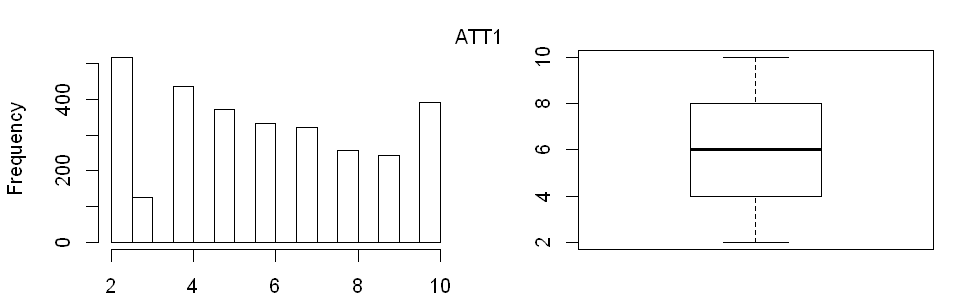

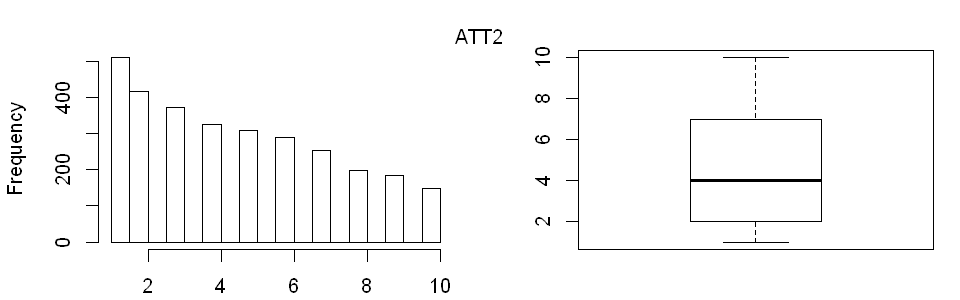

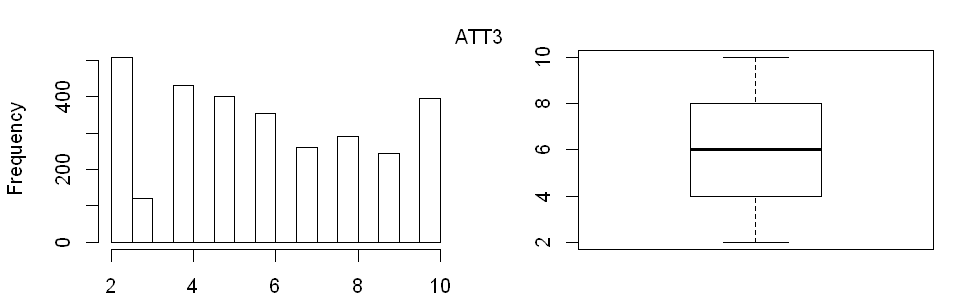

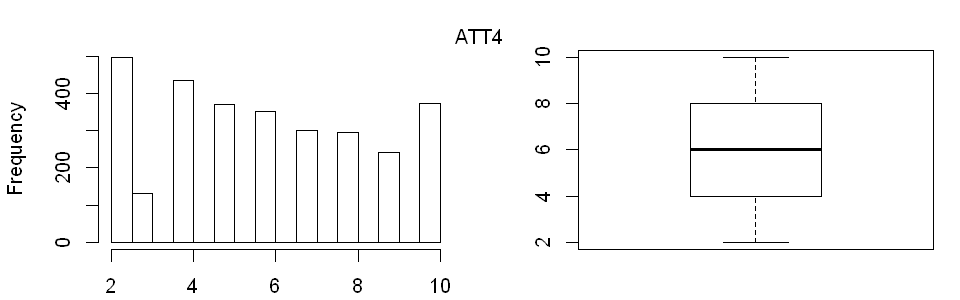

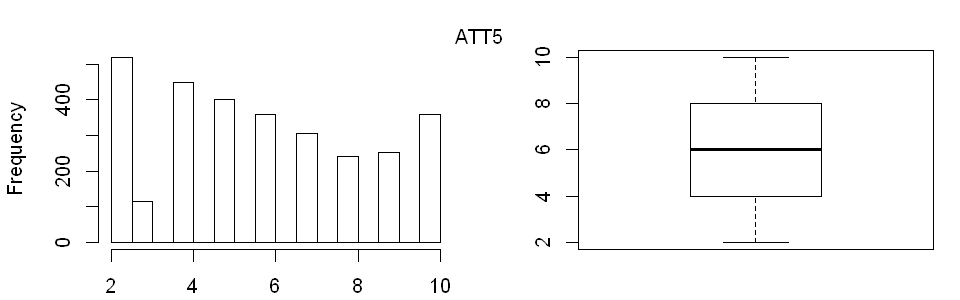

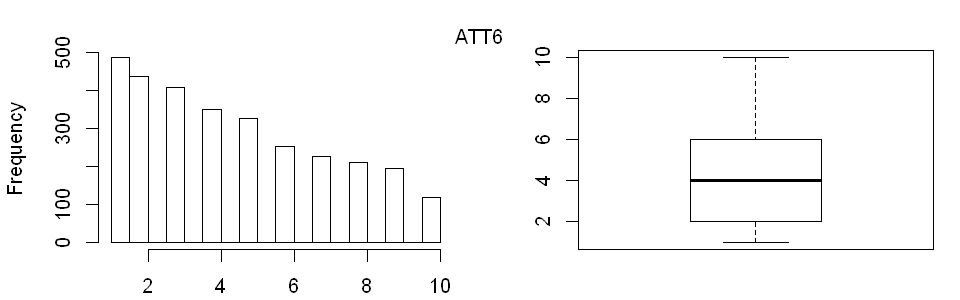

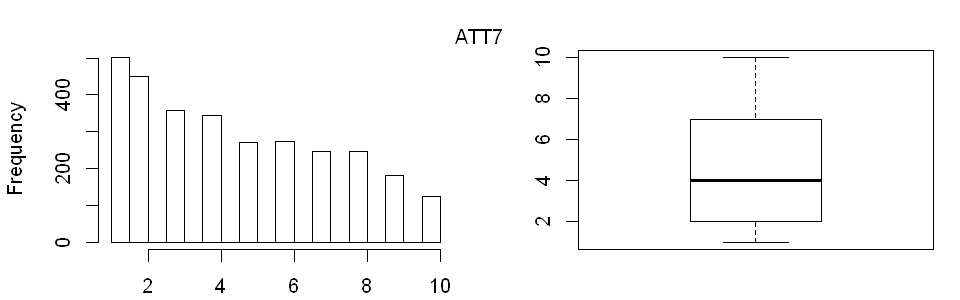

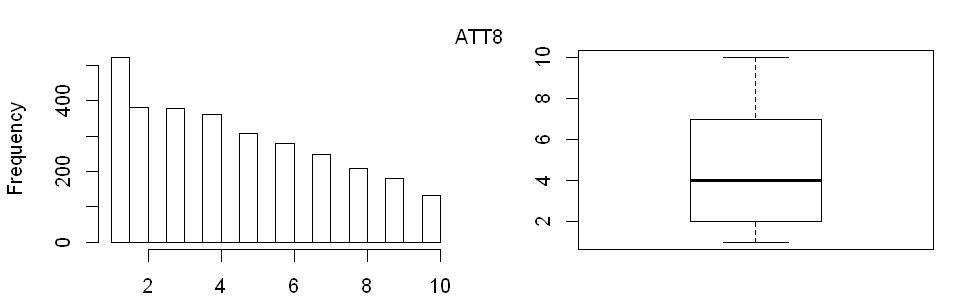

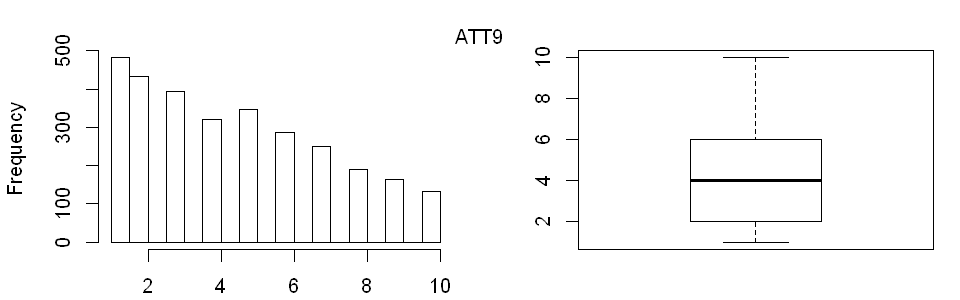

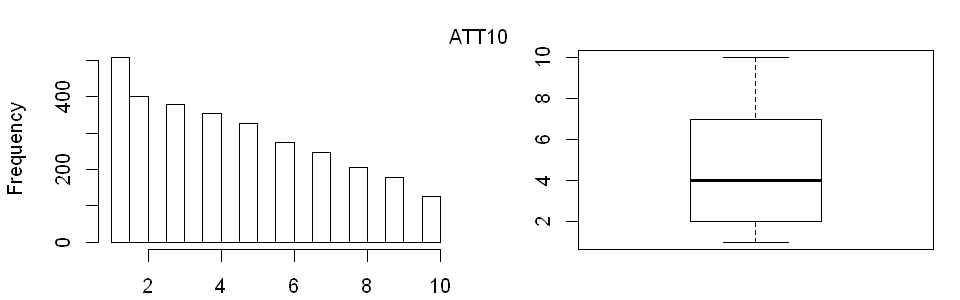

In [13]:
oldpar <- par() #this records all the default settings
par(mfrow=c(1,2)) # this makes to plots in one row
par(mar=c(2.1,4.1,2.1,1.1)) #BLTR
options(repr.plot.width=8, repr.plot.height=2.5)
for (i in names(prostate)) {
    if (i != "Result") {
        hist(prostate[[i]],xlab=NULL,main=NULL)
        boxplot(prostate[[i]])
        mtext(i,side=3,line=-2, outer=TRUE)
    }
}
suppressWarnings( par(oldpar)) # Restore settings

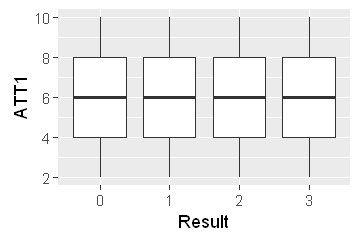

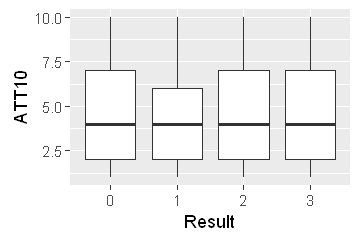

In [14]:
options(repr.plot.width = 3)
options(repr.plot.height = 2)
ggplot(prostate, aes(x = Result, y = ATT1)) + geom_boxplot()
#ggplot(prostate, aes(x = Result, y = ATT2)) + geom_boxplot()
#ggplot(prostate, aes(x = Result, y = ATT3)) + geom_boxplot()
#ggplot(prostate, aes(x = Result, y = ATT4)) + geom_boxplot()
#ggplot(prostate, aes(x = Result, y = ATT5)) + geom_boxplot()
#ggplot(prostate, aes(x = Result, y = ATT6)) + geom_boxplot()
#ggplot(prostate, aes(x = Result, y = ATT7)) + geom_boxplot()
#ggplot(prostate, aes(x = Result, y = ATT8)) + geom_boxplot()
#ggplot(prostate, aes(x = Result, y = ATT9)) + geom_boxplot()
ggplot(prostate, aes(x = Result, y = ATT10)) + geom_boxplot()
options(repr.plot.width = 6)
options(repr.plot.height = 4)

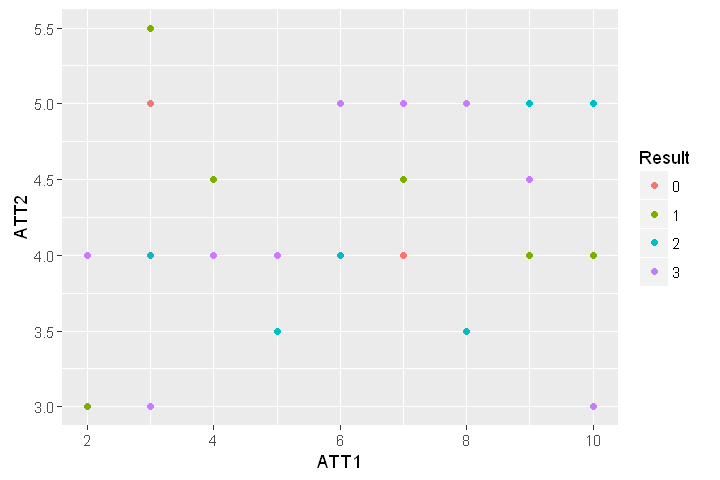

In [15]:
ggplot(aes(x=ATT1, y=ATT2, color=Result),  #by setting color=color, ggplot automatically draw in different colors
       data=prostate) + geom_point(stat='summary', fun.y=median)

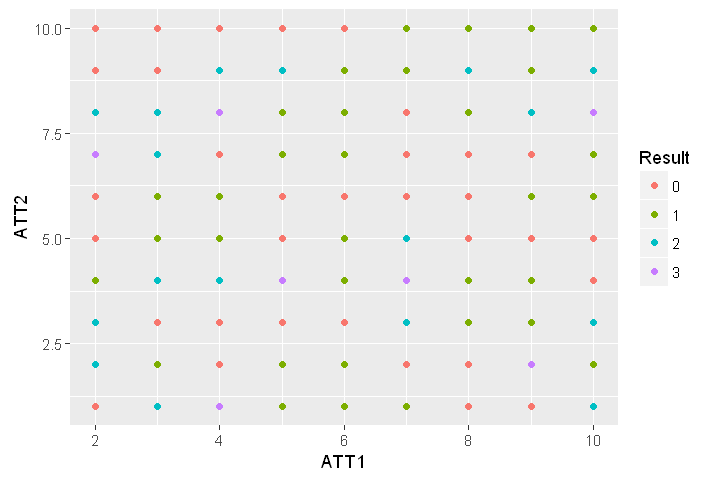

In [16]:
qplot(ATT1, ATT2, colour=Result, data=prostate)

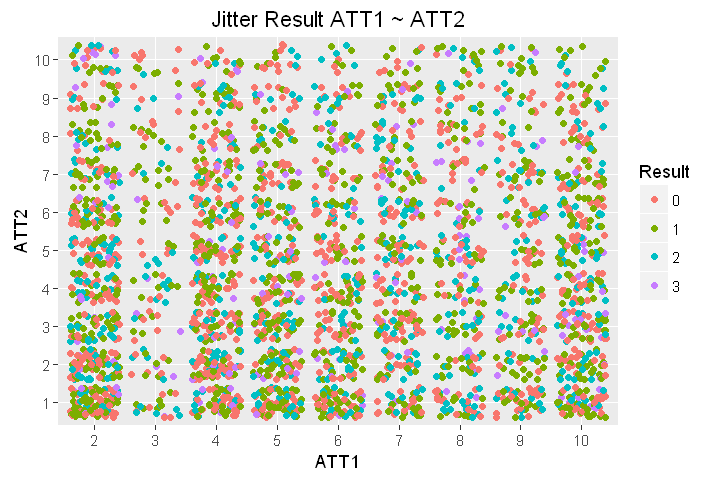

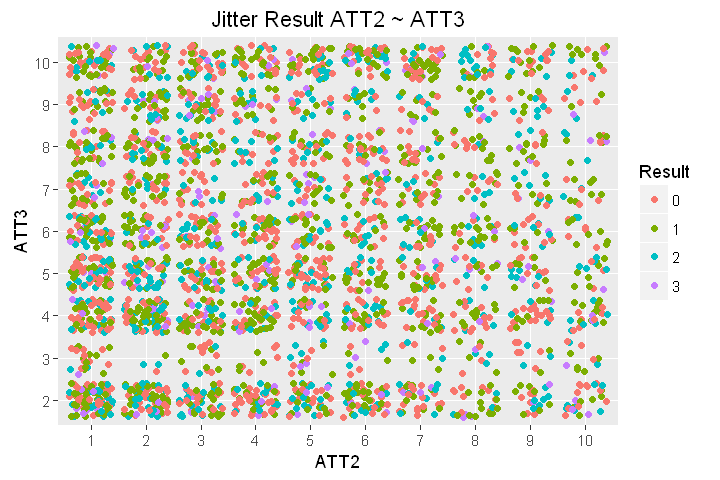

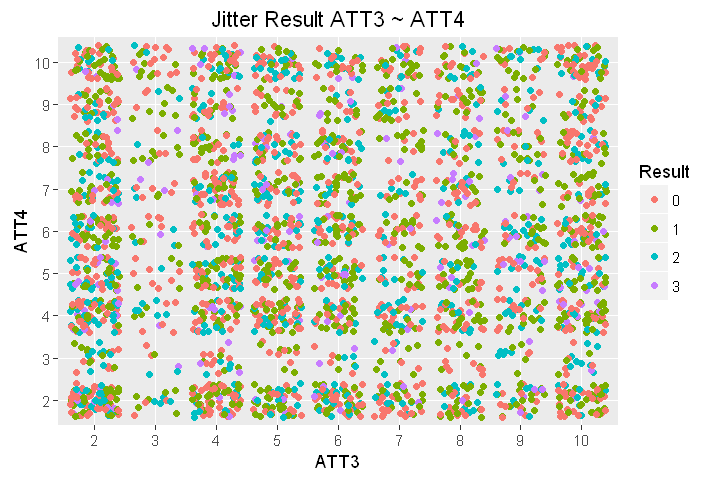

In [17]:
Udf.Utilities.Jitter(prostate,"ATT1","ATT2","Result")
Udf.Utilities.Jitter(prostate, "ATT2", "ATT3", "Result")
Udf.Utilities.Jitter(prostate, "ATT3", "ATT4", "Result")

In [125]:
head(prostate)

,ATT1,ATT2,ATT3,ATT4,ATT5,ATT6,ATT7,ATT8,ATT9,ATT10,Result
1,2,4,2,6,5,7,1,2,6,8,1
2,5,8,10,2,2,1,1,5,6,1,2
3,3,7,7,9,2,5,2,7,1,1,2
4,5,4,5,9,4,8,4,6,7,2,1
5,5,5,4,2,8,5,3,1,7,1,3
6,4,7,5,4,2,4,10,3,9,5,1


In [133]:
# drop Result back to numeric temporarily to see correclations
prostate$Result <- as.numeric(prostate$Result)-1 

# show each of the correlations with price
cor(prostate[sapply(prostate, is.numeric)])[,'Result']

prostate$Result <- as.factor(prostate$Result) 

ATT1       ATT2       ATT3       ATT4       ATT5       ATT6       ATT7 
 0.0086519 -0.0038396  0.0002549 -0.0100007 -0.0020528  0.0006346 -0.0352600 
      ATT8       ATT9      ATT10     Result 
-0.0380930 -0.0215929  0.0077091  1.0000000

All showing very weak correlations with the target variable - Result. This will make life interesting 

---
# 2. EDA Report

Perform an EDA, and prepare a summary of your findings. The summary should be less than 300 words. You need to emphasise on the aspects of the EDA that guide you in choosing a particular model or algorithm for your classifier. If you want to include any chart in your notebook, there should be something you have learnt and you are going to use it in your model selection. Please provide a short explanation on what you have learnt just after the cell. In addition, types of variables, the dimension of the data, and any correlation between variables are very important. Also, you might need to look at some distribution of your variables to get some insights.

### Train/Test split
Before we do anything, dedicate 20% of our data to an unseen Test set.

In [134]:
# 20% of the sample size
smp_size <- floor(0.8 * nrow(prostate))

set.seed(seed)
train_ind <- sample(seq_len(nrow(prostate)), size = smp_size)

train <- prostate[train_ind, ]
test <- prostate[-train_ind, ]

---
# 3. XGBoost

In [137]:
# create an upsample of training to obtain an even split of classes
# note that other sampling methods (down, SMOTE) were tried with less success
xg_train <- Udf.Utilities.UpSample(train)

xg_test <- test

In [138]:
# Check the proportions of each factor within the Result variable
w <- table(xg_train$Result)
w


  0   1   2   3 
876 876 876 876 

In [139]:
# set the target for XGBoost to a numeric range from 0 - 3
xg_train.y <- as.numeric(xg_train$Result)-1
xg_test.y <- as.numeric(test$Result)-1

In [140]:
# store the actuals for future comparison
actual <- xg_test.y

In [141]:
# convert to matrix for boosting method
xg_train <- sparse.model.matrix(Result ~ ., data = xg_train)
dtrain <- xgb.DMatrix(data=xg_train, label=xg_train.y)

In [142]:
xg_test <- sparse.model.matrix(Result ~ ., data = xg_test)
dtest <- xgb.DMatrix(data=xg_test, label=xg_test.y)

In [143]:
watchlist <- list(xg_train=dtrain)

In [145]:
# set default params to be used if we don't have the compute power to perform this gridsearch
nrounds <- 500
max_depth <- 6
eta <- 0.1
colsample_bytree <- 0.9
subsample <- 0.9
gamma <- 0
min_child_weight <- 1

In [146]:
# cross validate to select optimal value for number of rounds
set.seed(seed)
n_rounds.cv <- 1000
params <- list(booster = "gbtree", objective = "multi:softmax",
               num_class = 4, eval_metric = 'merror',
               max_depth = max_depth, eta = eta,
               colsample_bytree = colsample_bytree, subsample = subsample, min_child_weight = min_child_weight)

In [70]:
bst.cv <- xgb.cv(params, dtrain, n_rounds.cv, nfold = 10, metrics = {'merror'},
                 print.every.n = 20, prediction = TRUE)

[0]	train-merror:0.508879+0.012468	test-merror:0.624680+0.024307
[20]	train-merror:0.176560+0.008523	test-merror:0.468025+0.029982
[40]	train-merror:0.100583+0.002541	test-merror:0.418943+0.031163
[60]	train-merror:0.061802+0.002610	test-merror:0.406106+0.027163
[80]	train-merror:0.036307+0.002331	test-merror:0.396708+0.024365
[100]	train-merror:0.021911+0.001830	test-merror:0.384998+0.024580
[120]	train-merror:0.013667+0.001957	test-merror:0.381288+0.025276
[140]	train-merror:0.007325+0.001342	test-merror:0.372162+0.028310
[160]	train-merror:0.004027+0.000748	test-merror:0.369870+0.031357
[180]	train-merror:0.002030+0.000477	test-merror:0.369019+0.029462
[200]	train-merror:0.001237+0.000484	test-merror:0.369307+0.028689
[220]	train-merror:0.000634+0.000473	test-merror:0.369020+0.025303
[240]	train-merror:0.000190+0.000401	test-merror:0.368169+0.024413
[260]	train-merror:0.000000+0.000000	test-merror:0.367882+0.024541
[280]	train-merror:0.000000+0.000000	test-merror:0.366731+0.021838
[

In [147]:
n_rounds.train <- which.min(bst.cv$dt[, test.merror.mean])
n_rounds.train

[1] 759

In [148]:
# create the model
bst <- xgb.train(   params              = params, 
                    data                = dtrain, 
                    nrounds             = n_rounds.train, 
                    verbose             = 1,
                    watchlist           = watchlist,
                    maximize            = FALSE
)

[0]	xg_train-merror:0.490011
[1]	xg_train-merror:0.413813
[2]	xg_train-merror:0.374144
[3]	xg_train-merror:0.340183
[4]	xg_train-merror:0.321062
[5]	xg_train-merror:0.292808
[6]	xg_train-merror:0.285388
[7]	xg_train-merror:0.278539
[8]	xg_train-merror:0.268836
[9]	xg_train-merror:0.258276
[10]	xg_train-merror:0.245434
[11]	xg_train-merror:0.238014
[12]	xg_train-merror:0.235445
[13]	xg_train-merror:0.227169
[14]	xg_train-merror:0.221747
[15]	xg_train-merror:0.214897
[16]	xg_train-merror:0.207477
[17]	xg_train-merror:0.195205
[18]	xg_train-merror:0.186073
[19]	xg_train-merror:0.188927
[20]	xg_train-merror:0.182934
[21]	xg_train-merror:0.179509
[22]	xg_train-merror:0.173231
[23]	xg_train-merror:0.167237
[24]	xg_train-merror:0.165525
[25]	xg_train-merror:0.158105
[26]	xg_train-merror:0.157249
[27]	xg_train-merror:0.153253
[28]	xg_train-merror:0.149258
[29]	xg_train-merror:0.141267
[30]	xg_train-merror:0.135845
[31]	xg_train-merror:0.130422
[32]	xg_train-merror:0.131564
[33]	xg_train-merror

In [73]:
# generate predictions from model
pred <- predict(bst, xg_test);

In [74]:
confusionMatrix(pred, actual)

Confusion Matrix and Statistics

          Reference
Prediction  0  1  2  3
         0 87 83 60 15
         1 82 78 60 18
         2 40 38 21  2
         3  5  5  6  0

Overall Statistics
                                        
               Accuracy : 0.31          
                 95% CI : (0.273, 0.349)
    No Information Rate : 0.357         
    P-Value [Acc > NIR] : 0.992882      
                                        
                  Kappa : -0.02         
 Mcnemar's Test P-Value : 0.000704      

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3
Sensitivity             0.407    0.382    0.143   0.0000
Specificity             0.591    0.596    0.823   0.9717
Pos Pred Value          0.355    0.328    0.208   0.0000
Neg Pred Value          0.642    0.652    0.747   0.9401
Prevalence              0.357    0.340    0.245   0.0583
Detection Rate          0.145    0.130    0.035   0.0000
Detection Prevalence    0.408    0.397    0.168   0.0267
Balan

In [75]:
feature.importance <- xgb.importance(dimnames(xg_train)[[2]], model = bst)
head(feature.importance)

,Feature,Gain,Cover,Frequence
1,ATT3,0.104013392229815,0.0884387812879234,0.100707140393239
2,ATT9,0.102409110367457,0.116503945866794,0.103535701966195
3,ATT4,0.102311142280264,0.0900530928434779,0.0998620213866851
4,ATT6,0.101093972495696,0.101818313112935,0.100793377026561
5,ATT10,0.100559832080534,0.106793830794048,0.100758882373232
6,ATT2,0.0995691186445694,0.10838137342493,0.100569161779924


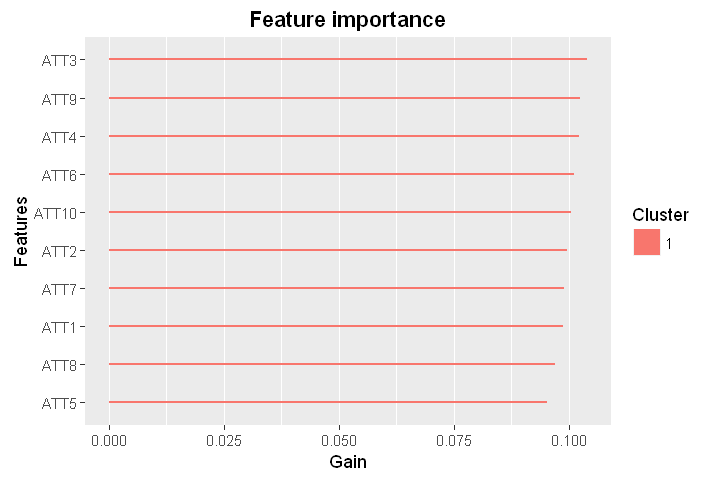

In [77]:
xgb.plot.importance(feature.importance)

## Cross Validate further parameters for XGBoost using GridSearch

In [79]:
xgbGrid <- expand.grid(
    nrounds = c(100, 300, 500, 1000),
    max_depth = c(1, 3, 5, 7),
    eta = c(0.001, 0.01, 0.1),
    gamma = c(0, 1),
    colsample_bytree = c(1, 0.9, 0.8),
    min_child_weight = c(1, 2, 3),
    subsample = c(1, 0.9, 0.8)
)

In [80]:
xgbTrControl <- trainControl(
    method = "repeatedcv",
    number = 5,
    repeats = 2,
    verboseIter = FALSE,
    returnData = FALSE,
    allowParallel = TRUE
)

In [81]:
xg_train <- Udf.Utilities.UpSample(train)
xg_train$Result <- as.numeric(xg_train$Result)-1
for(i in c(1:ncol(xg_train))) {
    xg_train[,i] <- as.numeric(xg_train[,i])
}

In [97]:
set.seed(seed)

# This is computationaly expensive - takes about an hour
"
xgbTrain <- train(
    x = as.matrix(xg_train[, ! names(xg_train) %in% c('Result')]), 
    y = xg_train$Result,
    objective = 'multi:softmax',
    trControl = xgbTrControl,
    tuneGrid = xgbGrid,
    method = 'xgbTree',
    num_class = 4,
    eval_metric = 'merror'
)
"

[1] "\nxgbTrain <- train(\n    x = as.matrix(xg_train[, ! names(xg_train) %in% c('Result')]), \n    y = xg_train$Result,\n    objective = 'multi:softmax',\n    trControl = xgbTrControl,\n    tuneGrid = xgbGrid,\n    method = 'xgbTree',\n    num_class = 4,\n    eval_metric = 'merror'\n)\n"

In [76]:
# get the top model and its results
#head(xgbTrain$results[with(xgbTrain$results, order(RMSE)), ], 5)

#    eta max_depth gamma colsample_bytree min_child_weight subsample nrounds   RMSE Rsquared  RMSESD RsquaredSD
#291 0.1         7     1              0.9                1       0.9    1000 0.8798   0.4809 0.06850    0.06617
#303 0.1         7     1              0.9                3       0.9    1000 0.8872   0.4755 0.05355    0.05192
#297 0.1         7     1              0.9                2       0.9    1000 0.8894   0.4725 0.05044    0.04991
#290 0.1         7     1              0.9                1       0.9     500 0.8931   0.4684 0.08039    0.07727
#308 0.1         7     1              1.0                1       0.9     500 0.8965   0.4639 0.09140    0.08873

In [96]:
nrounds <- 1000
max_depth <- 7
eta <- 0.1
colsample_bytree <- 0.9
subsample <- 0.9
gamma <- 1
min_child_weight <- 1

In [97]:
# Alter the params based on the best performing set of params abvove
params <- list(booster = "gbtree", objective = "multi:softmax",
               num_class = 4, eval_metric = 'merror',
               max_depth = max_depth, eta = eta,
               colsample_bytree = colsample_bytree, subsample = subsample,
               gamma = gamma, min_child_weight = min_child_weight)

In [98]:
bst.cv <- xgb.cv(params, dtrain, n_rounds.cv, nfold = 10, metrics = {'merror'},
                 print.every.n = 20, prediction = TRUE)

[0]	train-merror:0.426434+0.016330	test-merror:0.565343+0.034453
[20]	train-merror:0.099885+0.006610	test-merror:0.414662+0.021840
[40]	train-merror:0.048991+0.003526	test-merror:0.396966+0.021885
[60]	train-merror:0.027492+0.002271	test-merror:0.388994+0.025789
[80]	train-merror:0.018043+0.001646	test-merror:0.386425+0.020517
[100]	train-merror:0.012493+0.001788	test-merror:0.378144+0.020487
[120]	train-merror:0.009481+0.002115	test-merror:0.381569+0.022932
[140]	train-merror:0.008117+0.001651	test-merror:0.376993+0.025118
[160]	train-merror:0.006754+0.001119	test-merror:0.378144+0.021260
[180]	train-merror:0.005835+0.000672	test-merror:0.377002+0.022930
[200]	train-merror:0.005137+0.000714	test-merror:0.375856+0.026370
[220]	train-merror:0.004503+0.000714	test-merror:0.374146+0.022770
[240]	train-merror:0.004154+0.000851	test-merror:0.373862+0.023589
[260]	train-merror:0.003900+0.000579	test-merror:0.374148+0.025777
[280]	train-merror:0.003520+0.000548	test-merror:0.373575+0.024606
[

In [99]:
n_rounds.train <- which.min(bst.cv$dt[, test.merror.mean])
n_rounds.train

[1] 759

In [100]:
# create the model
bst <- xgb.train(   params              = params, 
                    data                = dtrain, 
                    nrounds             = n_rounds.train, 
                    verbose             = 1,
                    watchlist           = watchlist,
                    maximize            = FALSE
)

[0]	xg_train-merror:0.443779
[1]	xg_train-merror:0.343322
[2]	xg_train-merror:0.303653
[3]	xg_train-merror:0.276256
[4]	xg_train-merror:0.248573
[5]	xg_train-merror:0.225742
[6]	xg_train-merror:0.203482
[7]	xg_train-merror:0.194635
[8]	xg_train-merror:0.182934
[9]	xg_train-merror:0.175228
[10]	xg_train-merror:0.159532
[11]	xg_train-merror:0.152112
[12]	xg_train-merror:0.143265
[13]	xg_train-merror:0.136701
[14]	xg_train-merror:0.136701
[15]	xg_train-merror:0.128710
[16]	xg_train-merror:0.122717
[17]	xg_train-merror:0.118151
[18]	xg_train-merror:0.111872
[19]	xg_train-merror:0.104452
[20]	xg_train-merror:0.100457
[21]	xg_train-merror:0.094178
[22]	xg_train-merror:0.091324
[23]	xg_train-merror:0.089897
[24]	xg_train-merror:0.089326
[25]	xg_train-merror:0.082477
[26]	xg_train-merror:0.079909
[27]	xg_train-merror:0.075057
[28]	xg_train-merror:0.071347
[29]	xg_train-merror:0.070776
[30]	xg_train-merror:0.067637
[31]	xg_train-merror:0.065639
[32]	xg_train-merror:0.064498
[33]	xg_train-merror

In [101]:
# generate predictions from model
pred <- predict(bst, xg_test);

In [102]:
confusionMatrix(pred, actual)

Confusion Matrix and Statistics

          Reference
Prediction  0  1  2  3
         0 90 78 56 18
         1 81 78 61 14
         2 37 40 27  2
         3  6  8  3  1

Overall Statistics
                                        
               Accuracy : 0.327         
                 95% CI : (0.289, 0.366)
    No Information Rate : 0.357         
    P-Value [Acc > NIR] : 0.943         
                                        
                  Kappa : 0.008         
 Mcnemar's Test P-Value : 0.013         

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3
Sensitivity             0.421    0.382    0.184  0.02857
Specificity             0.606    0.606    0.826  0.96991
Pos Pred Value          0.372    0.333    0.255  0.05556
Neg Pred Value          0.654    0.656    0.757  0.94158
Prevalence              0.357    0.340    0.245  0.05833
Detection Rate          0.150    0.130    0.045  0.00167
Detection Prevalence    0.403    0.390    0.177  0.03000
Balan

### Why/when to use Gradient Boosted Trees

We chose 

There are two main reasons why you would use Random Forests over Gradient Boosted Decision Trees, and they are both pretty related:

RF are much easier to tune than GBM
RF are harder to overfit than GBM
Related to (1), RF basically has only one hyperparameter to set: the number of features to randomly select at each node. However there is a rule-of-thumb to use the square root of the number of total features which works pretty well in most cases[1]. On the other hand, GBMs have several hyperparameters that include the number of trees, the depth (or number of leaves), and the shrinkage (or learning rate).

And, regarding (2), while it is not true that RF do not overfit (as opposed as many are led to believe by Breiman's strong assertions[2]), it is true that they are more robust to overfitting and require less tuning to avoid it.

In some sense, RF is a tree ensemble that is more "plug'n'play" than GBM. However, it is generally true that a well-tuned GBM can outperform a RF.

Also, as Tianqi Chen mentioned, RF has traditionally been easier to parallelism. However, that is not a good reason anymore given there are efficient ways to do it with GBMs also

Practically, in almost all the cases, if you have to choose one method. Boosted Trees (GBM) is usually be preferred than RF if you tune the parameter carefully.  

The major reason is in terms of training objective, Boosted Trees(GBM) tries to add new trees that compliments the already built ones.  This normally gives you better accuracy with less trees.

This being said, the ideas of subsampling and bagging in RF is important. They can readily be incorporated into boosted tree training. This will indeed help the performance usually.

There is a historical reason such that RF is easier to parallelize. This can also be done for boosted trees, though less trivial. Boosted Trees can be distributed and very fast.   We did it in dmlc/xgboost  and it works pretty well.

One last advantage of boosted trees are about modeling, because boosted trees are derived by optimizing a objective function, basically it can be used to solve almost all objective you can write gradient out. This including things like ranking, poission regression, which RF is harder to achieve. We have a tutorial describing this perspective Introduction to Boosted Trees


Algorithmic difference is; Random Forests are trained with random sample of data (even more randomized cases available like feature randomization) and it trusts randomization to have better generalization performance on out of train set.
On the other spectrum, Gradient Boosted Trees algorithm additionally tries to find optimal linear combination of trees (assume final model is the weighted sum of predictions of individual trees) in relation to given train data. This extra tuning might be deemed as the difference. Note that, there are many variations of those algorithms as well. 

At the practical side; owing to this tuning stage, Gradient Boosted Trees are more susceptible to jiggling data. This final stage makes GBT more likely to overfit therefore if the test cases are inclined to be so verbose compared to train cases this algorithm starts lacking. On the contrary, Random Forests are better to strain on overfitting although it is lacking on the other way around. 

So the best choice depends to the case your have as always.

Dimensiality - Boosted trees are the method of choice in low (< 100) dimension settings. Random forests are the better choice in high-dimension settings.

Ideally, at the end of the project we would like to be able to convey how the prediction model is working under the hood to doctors who use it. They will be able to bring domain expertise to the problem if they can see how the model is working. This is one benefit of using a Tree based model. This is reduced somewhat as we bring in aspects such as Boosting and Random Forests, however.

After using the method, we were unable to improve the predictive accuracy much beyond 34%. Much of this was due to not having the compute power to effectively tune the hyperparameters. Given we were very unsure about our data, we needed to tune heavily, especially since we were seeing many cases of train error rates much lower than test. Avoiding over-fitting proved to be the demise of this method.


# 4. Random Forest

Given that our EDA failed to show up any strong correlations between variables, we are a little unsure if there are any strong predictors (relatively) in the dataset. We need to ensure that our tree gives a fair consideration to all of the features to ensure we don't head towards a local minima. This is where the Random Forst approach will come in. The method takes random samples of predictors at each split and only one is chosen from this set. So we can have decisions where the most optimal/important feature is not included for consideration. 

In [370]:
# create an upsample of training to obtain an even split of classes
set.seed(seed)
rforest_train <- Udf.Utilities.UpSample(train)

In [ ]:
control <- trainControl(method="repeatedcv", number=10, repeats=3)
seed <- seed
metric <- "Accuracy"
set.seed(seed)
#mtry <- sqrt(ncol(x))
tunegrid <- expand.grid(.mtry=c(2, 3, 4))
rf_default <- train(Result ~., data=rforest_train, method="rf", metric=metric, tuneGrid=tunegrid, trControl=control)
print(rf_default)

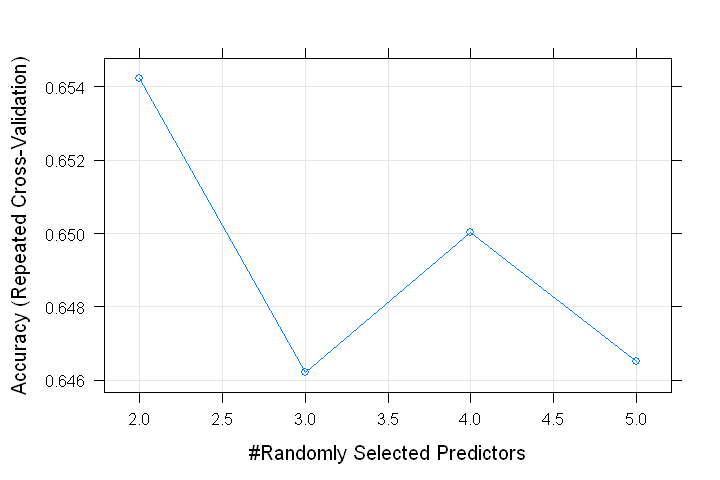

In [361]:
plot(rf_default)

In [363]:
pred_rf <- predict(rf_default, test)

In [364]:
confusionMatrix(pred_rf, actual)

Confusion Matrix and Statistics

          Reference
Prediction   0   1   2   3
         0  88  78  65  17
         1 100 100  69  17
         2  24  23  13   1
         3   2   3   0   0

Overall Statistics
                                         
               Accuracy : 0.335          
                 95% CI : (0.297, 0.374) 
    No Information Rate : 0.357          
    P-Value [Acc > NIR] : 0.875          
                                         
                  Kappa : 0              
 Mcnemar's Test P-Value : 0.0000000000015

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3
Sensitivity             0.411    0.490   0.0884  0.00000
Specificity             0.585    0.530   0.8940  0.99115
Pos Pred Value          0.355    0.350   0.2131  0.00000
Neg Pred Value          0.642    0.669   0.7514  0.94118
Prevalence              0.357    0.340   0.2450  0.05833
Detection Rate          0.147    0.167   0.0217  0.00000
Detection Prevalence    0.413    0

In [368]:
print(importance(rf_default$finalModel,type = 2))

      MeanDecreaseGini
ATT1             252.7
ATT2             265.7
ATT3             255.7
ATT4             253.6
ATT5             249.9
ATT6             257.5
ATT7             257.5
ATT8             263.8
ATT9             256.6
ATT10            262.7


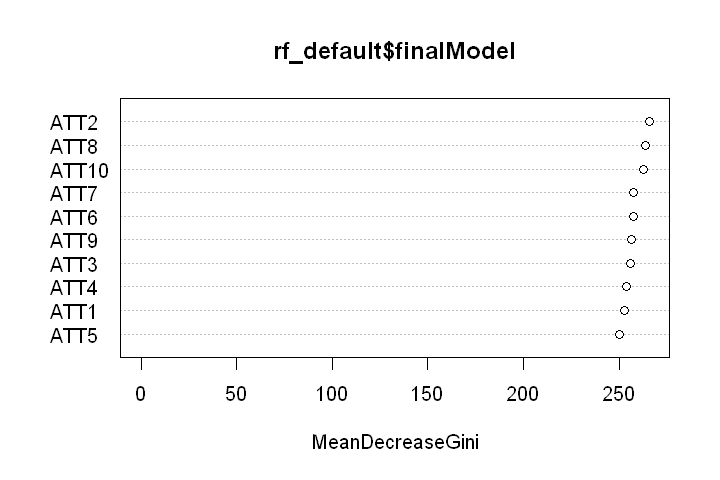

In [369]:
options(repr.plot.width = 6)
options(repr.plot.height = 4)
varImpPlot(rf_default$finalModel)

## Cross Validation for Random Forest feature selection 

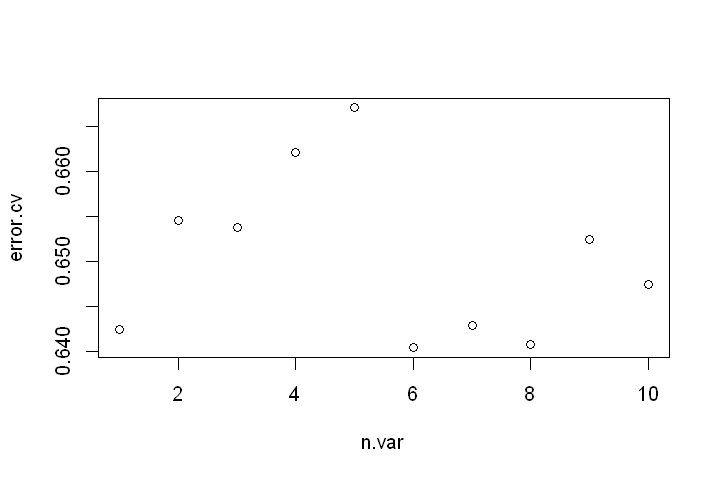

In [273]:
x <- train
x$Result <- NULL
y <- train$Result

rf.cv <- rfcv(x, y, cv.fold=10, step=0.9)

set.seed(seed)
with(rf.cv, plot(n.var, error.cv))

Ok, this is telling us that a model with all features may not be best. Let's try retrain the model without the lowest importance features and rerun the predictions

In [263]:
rforest <- randomForest(Result ~ . - ATT1, data = rforest_train, mtry=4, ntree=10000, sampsize=1000)
rforest


Call:
 randomForest(formula = Result ~ . - ATT1, data = rforest_train,      mtry = 4, ntree = 10000, sampsize = 1000) 
               Type of random forest: classification
                     Number of trees: 10000
No. of variables tried at each split: 4

        OOB estimate of  error rate: 36.76%
Confusion matrix:
    0   1   2   3 class.error
0 336 303 168  69    0.616438
1 304 323 183  66    0.631279
2  73  96 683  24    0.220320
3   2   0   0 874    0.002283

In [270]:
rforest <- randomForest(Result ~ ATT2+ATT4+ATT6+ATT8+ATT9+ATT10, data = rforest_train, mtry=4, ntree=10000, sampsize=1000)

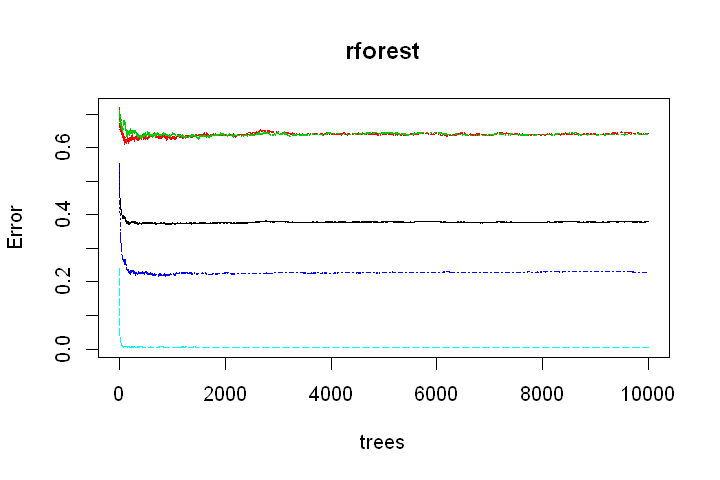

In [328]:
plot(rforest)

In [264]:
print(importance(rforest,type = 2))

      MeanDecreaseGini
ATT2             84.69
ATT3             80.60
ATT4             82.40
ATT5             80.17
ATT6             83.62
ATT7             82.56
ATT8             85.57
ATT9             84.04
ATT10            84.96


In [271]:
pred_rforest <- predict(rforest, test)

In [272]:
confusionMatrix(pred_rforest, actual)

Confusion Matrix and Statistics

          Reference
Prediction  0  1  2  3
         0 71 66 51 13
         1 73 63 48 13
         2 46 55 32  6
         3 24 20 16  3

Overall Statistics
                                       
               Accuracy : 0.282        
                 95% CI : (0.246, 0.32)
    No Information Rate : 0.357        
    P-Value [Acc > NIR] : 1.000        
                                       
                  Kappa : -0.017       
 Mcnemar's Test P-Value : 0.109        

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3
Sensitivity             0.332    0.309   0.2177   0.0857
Specificity             0.663    0.662   0.7638   0.8938
Pos Pred Value          0.353    0.320   0.2302   0.0476
Neg Pred Value          0.642    0.650   0.7505   0.9404
Prevalence              0.357    0.340   0.2450   0.0583
Detection Rate          0.118    0.105   0.0533   0.0050
Detection Prevalence    0.335    0.328   0.2317   0.1050
Balanced Accu

# 5. Deep Learning

In [11]:
obj_ <- Udf.Utilities.PrepareTraining(prostate)
tr_ <- obj_$training
ts_ <- obj_$testing

In [ ]:
h2o.init(nthreads = -1)

In [ ]:
# What are these for?
tr_ <- read.csv("trFE.csv")
ts_ <- read.csv("tsFE.csv")
tr_$Result <- as.factor(tr_$Result)
ts_$Result <- as.factor(ts_$Result)

# 6. Turbo Boost

In [167]:
# Make training and test sets
#obj_ <- Udf.Utilities.PrepareTraining(prostate)
tr_ <- train#obj_$training
ts_ <- test#obj_$testing
actual <- ts_$Result

In [168]:
# PCA
pc_ <- Udf.Utilities.Prcomp(tr_[,-ncol(tr_)],nComps = 2)

pcObj_ <- pc_$prcompObj # Get object 

tr_ <- cbind(tr_,pc_$components) # bind to features.

In [169]:
# do the same to the test set
pc_ts <- Udf.Utilities.Prcomp(ts_[,-ncol(ts_)],nComps = 2)

pcObj_ts<- pc_ts$prcompObj # Get object 

ts_ <- cbind(ts_,pc_ts$components) # bind to features.

In [53]:
# Control method
ctrl_ <- trainControl(method = "cv", number = 5, sampling = "up")
mdl.xgb <- train(Result ~ . , data = tr_, method = "xgbTree", trControl = ctrl_)

In [173]:
pred_xgb_prcomp <- predict(mdl.xgb, ts_)

In [174]:
confusionMatrix(actual, pred_xgb_prcomp)

Confusion Matrix and Statistics

          Reference
Prediction  0  1  2  3
         0 80 74 45 15
         1 71 89 36  8
         2 50 61 26 10
         3 15 12  6  2

Overall Statistics
                                        
               Accuracy : 0.328         
                 95% CI : (0.291, 0.368)
    No Information Rate : 0.393         
    P-Value [Acc > NIR] : 1.000         
                                        
                  Kappa : 0.024         
 Mcnemar's Test P-Value : 0.199         

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3
Sensitivity             0.370    0.377   0.2301  0.05714
Specificity             0.651    0.684   0.7515  0.94159
Pos Pred Value          0.374    0.436   0.1769  0.05714
Neg Pred Value          0.648    0.629   0.8079  0.94159
Prevalence              0.360    0.393   0.1883  0.05833
Detection Rate          0.133    0.148   0.0433  0.00333
Detection Prevalence    0.357    0.340   0.2450  0.05833
Balan

In [60]:
mdl.gbm <- train(Result ~ . , data = tr_,method = "gbm", trControl = ctrl_)
pred_gbm <- predict(mdl.gbm, ts_)

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.3863             nan     0.1000    0.0006
     2        1.3843             nan     0.1000   -0.0011
     3        1.3829             nan     0.1000    0.0010
     4        1.3814             nan     0.1000   -0.0004
     5        1.3799             nan     0.1000   -0.0001
     6        1.3785             nan     0.1000   -0.0004
     7        1.3773             nan     0.1000   -0.0002
     8        1.3760             nan     0.1000   -0.0009
     9        1.3748             nan     0.1000   -0.0001
    10        1.3739             nan     0.1000    0.0001
    20        1.3650             nan     0.1000   -0.0007
    40        1.3519             nan     0.1000   -0.0010
    60        1.3435             nan     0.1000   -0.0012
    80        1.3368             nan     0.1000   -0.0011
   100        1.3311             nan     0.1000   -0.0016
   120        1.3264             nan     0.1000   -0.0016
   140        

In [61]:
confusionMatrix(actual, pred_gbm)

Confusion Matrix and Statistics

          Reference
Prediction  0  1  2  3
         0 69 57 52 36
         1 62 55 57 30
         2 32 40 41 34
         3 16  6  4  9

Overall Statistics
                                        
               Accuracy : 0.29          
                 95% CI : (0.254, 0.328)
    No Information Rate : 0.298         
    P-Value [Acc > NIR] : 0.687         
                                        
                  Kappa : 0.028         
 Mcnemar's Test P-Value : 0.000000000398

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3
Sensitivity             0.385   0.3481   0.2662   0.0826
Specificity             0.656   0.6629   0.7623   0.9470
Pos Pred Value          0.322   0.2696   0.2789   0.2571
Neg Pred Value          0.715   0.7399   0.7506   0.8230
Prevalence              0.298   0.2633   0.2567   0.1817
Detection Rate          0.115   0.0917   0.0683   0.0150
Detection Prevalence    0.357   0.3400   0.2450   0.0583
Balan

---
# 7. KNN Classification

In [347]:
knn_train <- train

In [348]:
set.seed(seed)
ctrl <- trainControl(method="repeatedcv",repeats = 5)
knnFit <- train(Result ~ ., 
                data = knn_train, 
                method = "knn", 
                trControl = ctrl, 
                preProcess = c("center","scale"),
                tuneLength = 20)

In [349]:
knnFit

k-Nearest Neighbors 

2400 samples
  10 predictor
   4 classes: '0', '1', '2', '3' 

Pre-processing: centered (10), scaled (10) 
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 2158, 2162, 2161, 2161, 2160, 2160, ... 
Resampling results across tuning parameters:

  k   Accuracy  Kappa     
   5  0.3327     0.0031361
   7  0.3398     0.0052320
   9  0.3456     0.0067162
  11  0.3454    -0.0001731
  13  0.3512     0.0059354
  15  0.3529     0.0050043
  17  0.3526     0.0021470
  19  0.3519    -0.0011296
  21  0.3497    -0.0065015
  23  0.3519    -0.0044468
  25  0.3467    -0.0140404
  27  0.3473    -0.0147368
  29  0.3413    -0.0244012
  31  0.3466    -0.0170929
  33  0.3448    -0.0208928
  35  0.3495    -0.0144542
  37  0.3500    -0.0144856
  39  0.3491    -0.0164655
  41  0.3541    -0.0095169
  43  0.3521    -0.0132306

Accuracy was used to select the optimal model using  the largest value.
The final value used for the model was k = 41. 

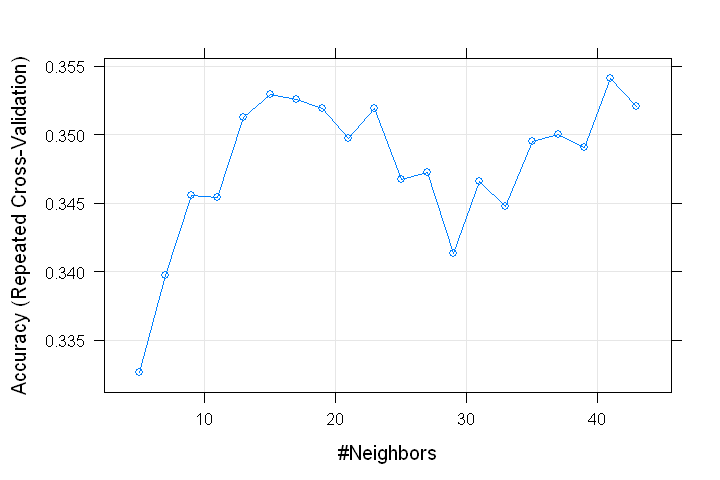

In [350]:
#Plotting yields Number of Neighbours Vs accuracy (based on repeated cross validation)
plot(knnFit)

In [351]:
pred_knn <- predict(knnFit,newdata = test )

In [352]:
confusionMatrix(actual, pred_knn )

Confusion Matrix and Statistics

          Reference
Prediction   0   1   2   3
         0 101 109   4   0
         1  91 110   3   0
         2  77  66   4   0
         3  21  13   1   0

Overall Statistics
                                             
               Accuracy : 0.358              
                 95% CI : (0.32, 0.398)      
    No Information Rate : 0.497              
    P-Value [Acc > NIR] : 1                  
                                             
                  Kappa : 0.019              
 Mcnemar's Test P-Value : <0.0000000000000002

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3
Sensitivity             0.348    0.369  0.33333       NA
Specificity             0.635    0.689  0.75680   0.9417
Pos Pred Value          0.472    0.539  0.02721       NA
Neg Pred Value          0.510    0.525  0.98234       NA
Prevalence              0.483    0.497  0.02000   0.0000
Detection Rate          0.168    0.183  0.00667   0.0000
De

---
# X. Ensemble the Predictions

In [320]:
# create a dataframe to store each of the predictions from each of the models we want to ensemble
preds_df <- data.frame(matrix(ncol = 0, nrow =600))

In [321]:
preds_df$pred_xgb <- pred_xgb
preds_df$pred_rforest <- pred_rforest
preds_df$pred_xgb_prcomp <- pred_xgb_prcomp
preds_df$pred_knn <- pred_knn

In [322]:
head(preds_df)

,pred_xgb,pred_rforest,pred_xgb_prcomp,pred_knn
1,1,3,1,1
2,1,1,1,1
3,0,0,0,0
4,0,1,0,1
5,1,2,1,0
6,0,3,0,0


In [323]:
table(preds_df$pred_xgb)


  0   1   2   3 
216 236 113  35 

In [324]:
preds_df <- Udf.Utilities.MajorityVotePredictions(preds_df)

In [325]:
head(preds_df)

,pred_xgb,pred_rforest,pred_xgb_prcomp,pred_knn,majority_pred
1,1,3,1,1,1
2,1,1,1,1,1
3,0,0,0,0,0
4,0,1,0,1,0
5,1,2,1,0,1
6,0,3,0,0,0


In [326]:
confusionMatrix(actual, preds_df$majority_pred)

Confusion Matrix and Statistics

          Reference
Prediction  0  1  2  3
         0 80 74 45 15
         1 71 89 36  8
         2 50 61 26 10
         3 15 12  6  2

Overall Statistics
                                        
               Accuracy : 0.328         
                 95% CI : (0.291, 0.368)
    No Information Rate : 0.393         
    P-Value [Acc > NIR] : 1.000         
                                        
                  Kappa : 0.024         
 Mcnemar's Test P-Value : 0.199         

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3
Sensitivity             0.370    0.377   0.2301  0.05714
Specificity             0.651    0.684   0.7515  0.94159
Pos Pred Value          0.374    0.436   0.1769  0.05714
Neg Pred Value          0.648    0.629   0.8079  0.94159
Prevalence              0.360    0.393   0.1883  0.05833
Detection Rate          0.133    0.148   0.0433  0.00333
Detection Prevalence    0.357    0.340   0.2450  0.05833
Balan

---
# X. Summary Report